In [ ]:
!pip install crcmod
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

!gsutil -m -o 'GSUtil:parallel_composite_upload_threshold_1M''GSUtil:sliced_object_download_max_components=8' cp -r gs://evenergy163.appspot.com/data/** .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for crcmod: filename=crcmod-1.7-cp311-cp311-linux_x86_64.whl size=31660 sha256=0af0f2ff82c1298c7d77ab86129a2fe05455d8052c2068b3750e5244b5bd213c
  Stored in directory: /root/.cache/pip/wheels/23/94/7a/8cb7d14597e6395ce969933f01aed9ea8fa5f5b4d4c8a61e99
Successfully built crcmod
Copying gs://evenergy163.appspot.com/data/evwatts.public.dictionary.txt...
Copying gs://evenergy163.appspot.com/data/Monthly Gas Prices.csv...
Copying gs://evenergy163.appspot.com/data/California Electric Rates.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.connector.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.session.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.evse.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehicles.csv...
Copying gs://evenergy163.appspot.com/data/evwatts.public.vehiclesessions.csv...


In [ ]:
session_data = pd.read_csv('evwatts.public.session.csv')
evse_data = pd.read_csv('evwatts.public.evse.csv')
#merging session data with evse data
merged_data = pd.merge(session_data, evse_data[['evse_id', 'charge_level', 'region', 'metro_area']], on='evse_id', how='left')
session_data = merged_data

session_data['start_datetime'] = pd.to_datetime(session_data['start_datetime'])
session_data['year_month'] = session_data['start_datetime'].dt.to_period('M').dt.to_timestamp()
#session_data.head(5)

In [ ]:
pacific_data = session_data[session_data['region'] == 'Pacific']
monthly_pacific = pacific_data.groupby('year_month')['session_id'].count().reset_index()
energy_pacific = pacific_data.groupby('year_month')['energy_kwh'].sum().reset_index()

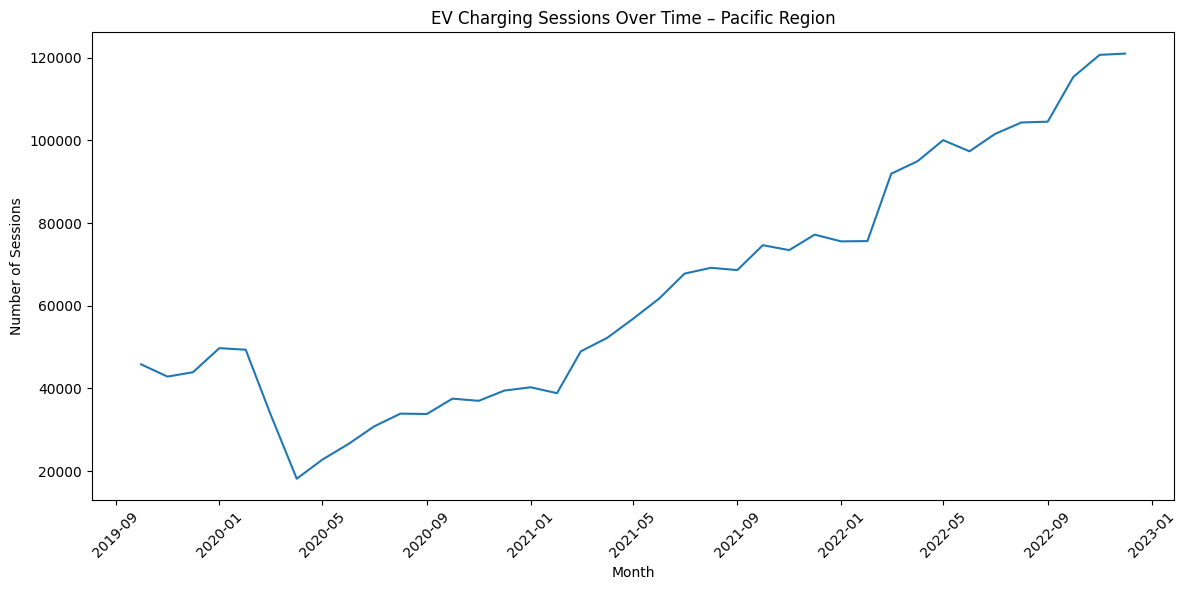

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_pacific, x='year_month', y='session_id')
plt.title('EV Charging Sessions Over Time – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Linear Regression R²: 0.8340
Linear Monthly Growth Rate: 3.71% per month

Exponential Regression R²: 0.9043
Exponential Monthly Growth Rate: 3.86% per month



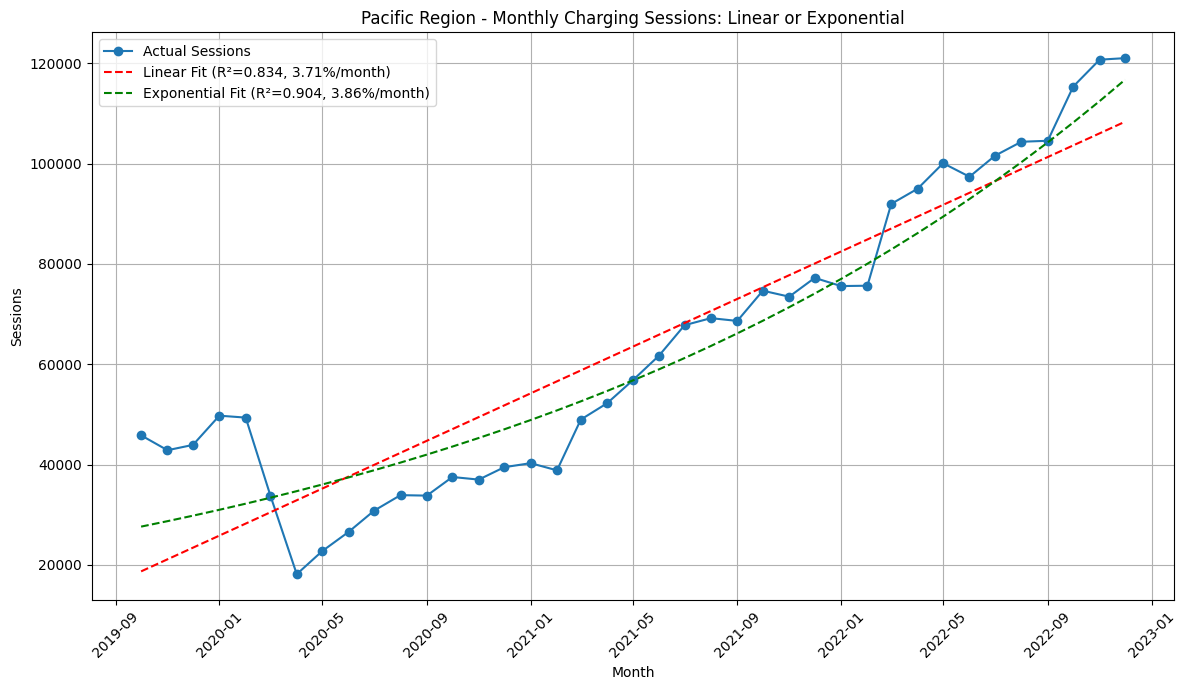

In [ ]:
monthly_pacific['year_month'] = pd.to_datetime(monthly_pacific['year_month'])
x_numeric = monthly_pacific['year_month'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = monthly_pacific['session_id'].values

# Linear Regression
linear_model = LinearRegression().fit(x_numeric, y)
y_linear_pred = linear_model.predict(x_numeric)
linear_r2 = linear_model.score(x_numeric, y)

# Calculate linear monthly growth percentage
daily_growth = linear_model.coef_[0]
monthly_growth = daily_growth * 30.44
monthly_percentage_growth_linear = (monthly_growth / y.mean()) * 100

# Exponential Regression
# Fit linear regression to log(y)
log_y = np.log(y)
exp_model = LinearRegression().fit(x_numeric, log_y)
log_y_pred = exp_model.predict(x_numeric)
y_exp_pred = np.exp(log_y_pred)

# Calculate R-squared for exponential fit
exp_r2 = r2_score(y, y_exp_pred)

# Monthly exponential growth rate (%)
daily_exp_growth_rate = exp_model.coef_[0]
monthly_exp_growth_rate = (np.exp(daily_exp_growth_rate * 30.44) - 1) * 100

# Print results clearly
print(f"Linear Regression R²: {linear_r2:.4f}")
print(f"Linear Monthly Growth Rate: {monthly_percentage_growth_linear:.2f}% per month\n")

print(f"Exponential Regression R²: {exp_r2:.4f}")
print(f"Exponential Monthly Growth Rate: {monthly_exp_growth_rate:.2f}% per month\n")

# Plot clearly
plt.figure(figsize=(12, 7))

# Actual data
plt.plot(monthly_pacific['year_month'], y, 'o-', label='Actual Sessions')

# Linear regression
plt.plot(monthly_pacific['year_month'], y_linear_pred, 'r--',
         label=f'Linear Fit (R²={linear_r2:.3f}, {monthly_percentage_growth_linear:.2f}%/month)')

# Exponential regression
plt.plot(monthly_pacific['year_month'], y_exp_pred, 'g--',
         label=f'Exponential Fit (R²={exp_r2:.3f}, {monthly_exp_growth_rate:.2f}%/month)')

plt.xlabel('Month')
plt.ylabel('Sessions')
plt.title('Pacific Region - Monthly Charging Sessions: Linear or Exponential')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Analysis of Monthly charging Session for pacific region
Here we see that in when focusing on the pacific region, we the exponential fitted better than the linear, with a 0.904 r2 score compared to 0.834 for linear. The pacific region charging session count is increasing by approximately 3.86% per month.

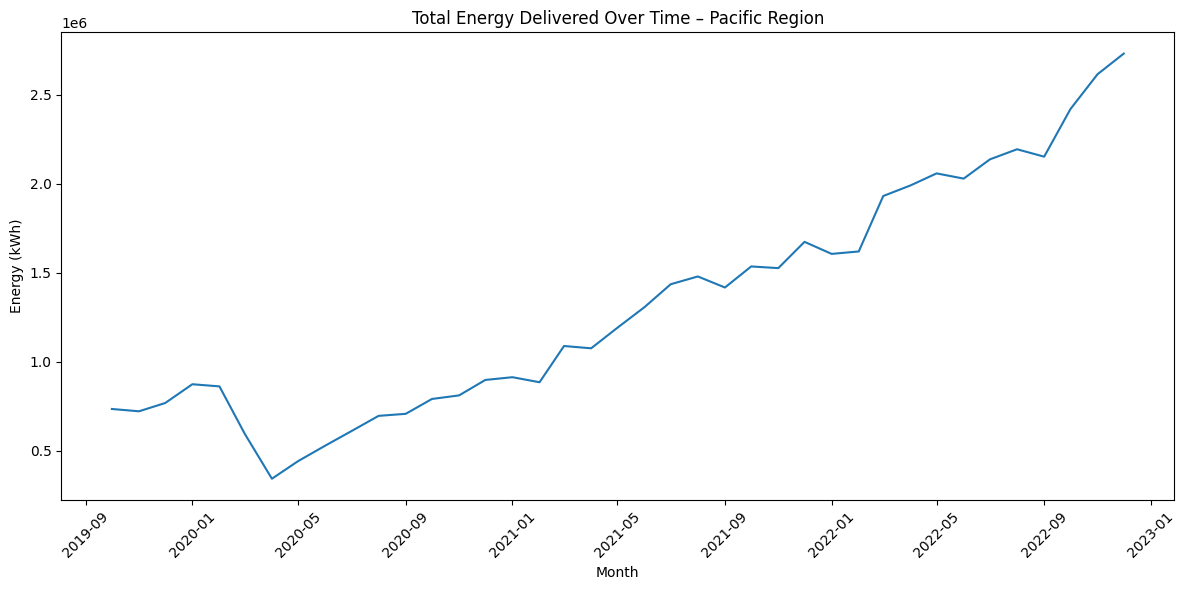

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=energy_pacific, x='year_month', y='energy_kwh')
plt.title('Total Energy Delivered Over Time – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Linear Regression R²: 0.8952
Linear Monthly Growth Rate: 4.09% per month

Exponential Regression R²: 0.9523
Exponential Monthly Growth Rate: 4.37% per month



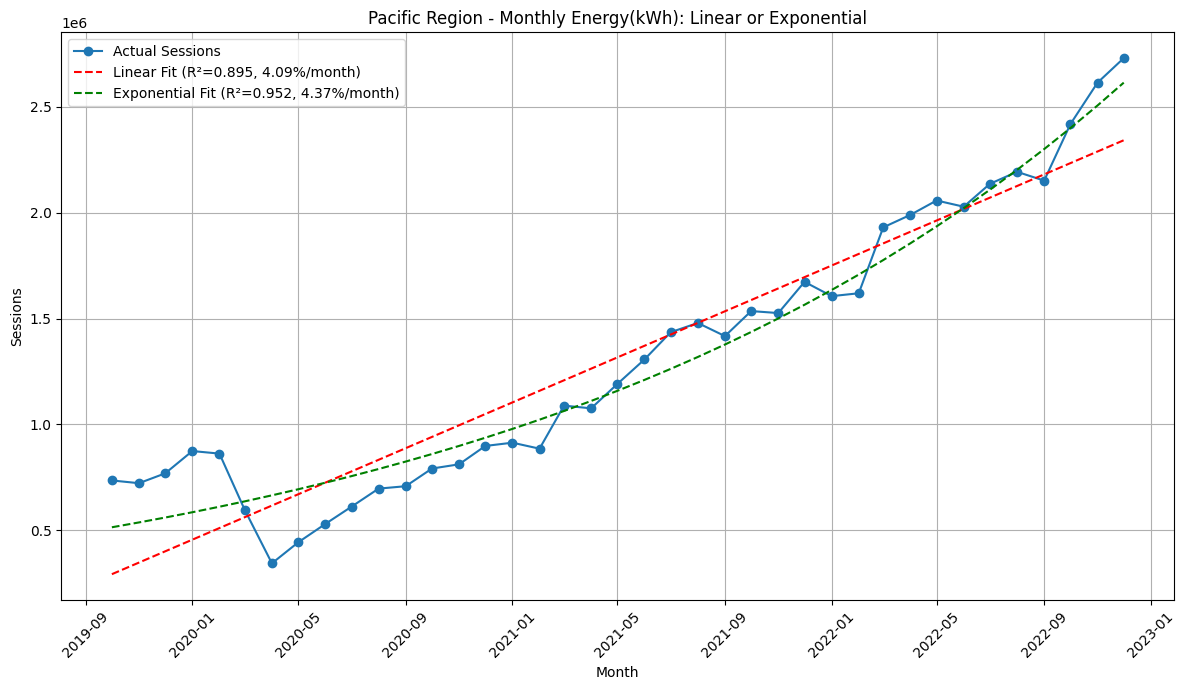

In [ ]:
energy_pacific['year_month'] = pd.to_datetime(energy_pacific['year_month'])
x_numeric = energy_pacific['year_month'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = energy_pacific['energy_kwh'].values

# Linear Regression
linear_model = LinearRegression().fit(x_numeric, y)
y_linear_pred = linear_model.predict(x_numeric)
linear_r2 = linear_model.score(x_numeric, y)

# Calculate linear monthly growth percentage
daily_growth = linear_model.coef_[0]
monthly_growth = daily_growth * 30.44
monthly_percentage_growth_linear = (monthly_growth / y.mean()) * 100

# Exponential Regression
# Fit linear regression to log(y)
log_y = np.log(y)
exp_model = LinearRegression().fit(x_numeric, log_y)
log_y_pred = exp_model.predict(x_numeric)
y_exp_pred = np.exp(log_y_pred)

# Calculate R-squared for exponential fit
exp_r2 = r2_score(y, y_exp_pred)

# Monthly exponential growth rate (%)
daily_exp_growth_rate = exp_model.coef_[0]
monthly_exp_growth_rate = (np.exp(daily_exp_growth_rate * 30.44) - 1) * 100

# Print results clearly
print(f"Linear Regression R²: {linear_r2:.4f}")
print(f"Linear Monthly Growth Rate: {monthly_percentage_growth_linear:.2f}% per month\n")

print(f"Exponential Regression R²: {exp_r2:.4f}")
print(f"Exponential Monthly Growth Rate: {monthly_exp_growth_rate:.2f}% per month\n")

# Plot clearly
plt.figure(figsize=(12, 7))

# Actual data
plt.plot(energy_pacific['year_month'], y, 'o-', label='Actual Sessions')

# Linear regression
plt.plot(energy_pacific['year_month'], y_linear_pred, 'r--',
         label=f'Linear Fit (R²={linear_r2:.3f}, {monthly_percentage_growth_linear:.2f}%/month)')

# Exponential regression
plt.plot(energy_pacific['year_month'], y_exp_pred, 'g--',
         label=f'Exponential Fit (R²={exp_r2:.3f}, {monthly_exp_growth_rate:.2f}%/month)')

plt.xlabel('Month')
plt.ylabel('Sessions')
plt.title('Pacific Region - Monthly Energy(kWh): Linear or Exponential')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Analysis of monthly energy usage in pacific region
Here, we also found a exponential trend like the charging session, where the exponetial fitted better. We found an approximate of 4.37% growth per month for energy usage in kWh.

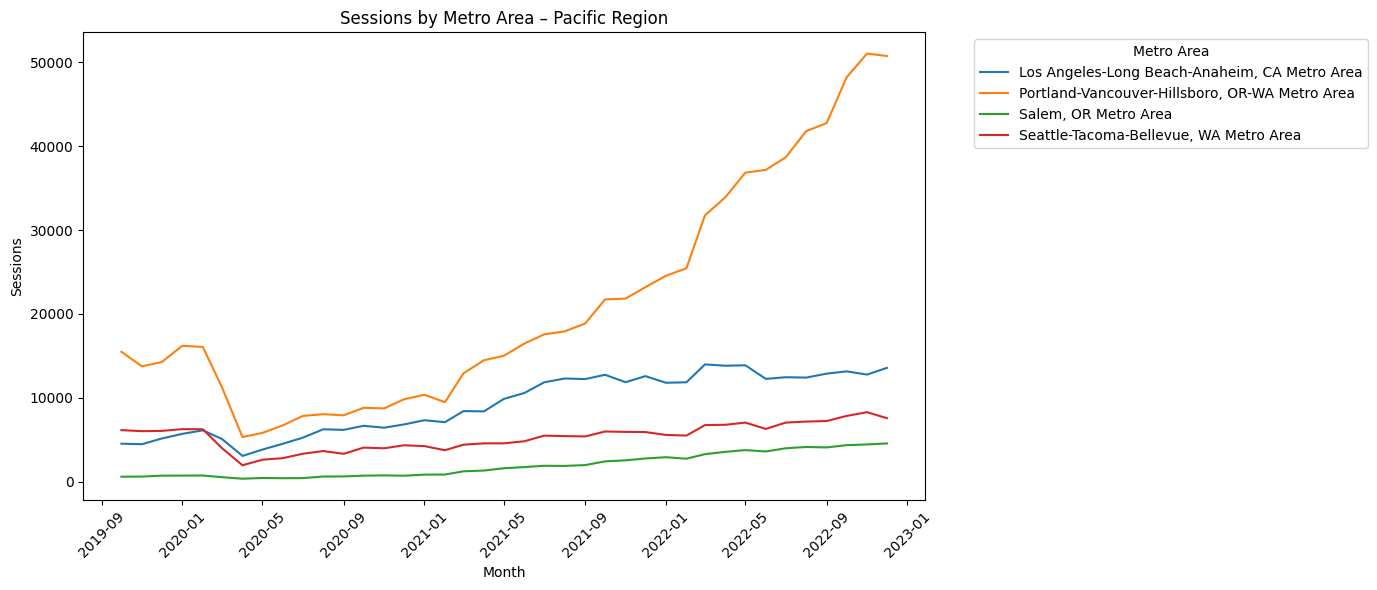

In [ ]:
non_undesignated_data = pacific_data[pacific_data['metro_area'] != 'Undesignated']
top_metros_pacific = non_undesignated_data['metro_area'].value_counts().head(5).index.tolist()

metro_monthly_pacific = pacific_data[pacific_data['metro_area'].isin(top_metros_pacific)] \
    .groupby(['year_month', 'metro_area'])['session_id'].count().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=metro_monthly_pacific, x='year_month', y='session_id', hue='metro_area')
plt.title('Sessions by Metro Area – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Sessions')
plt.xticks(rotation=45)
plt.legend(title='Metro Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


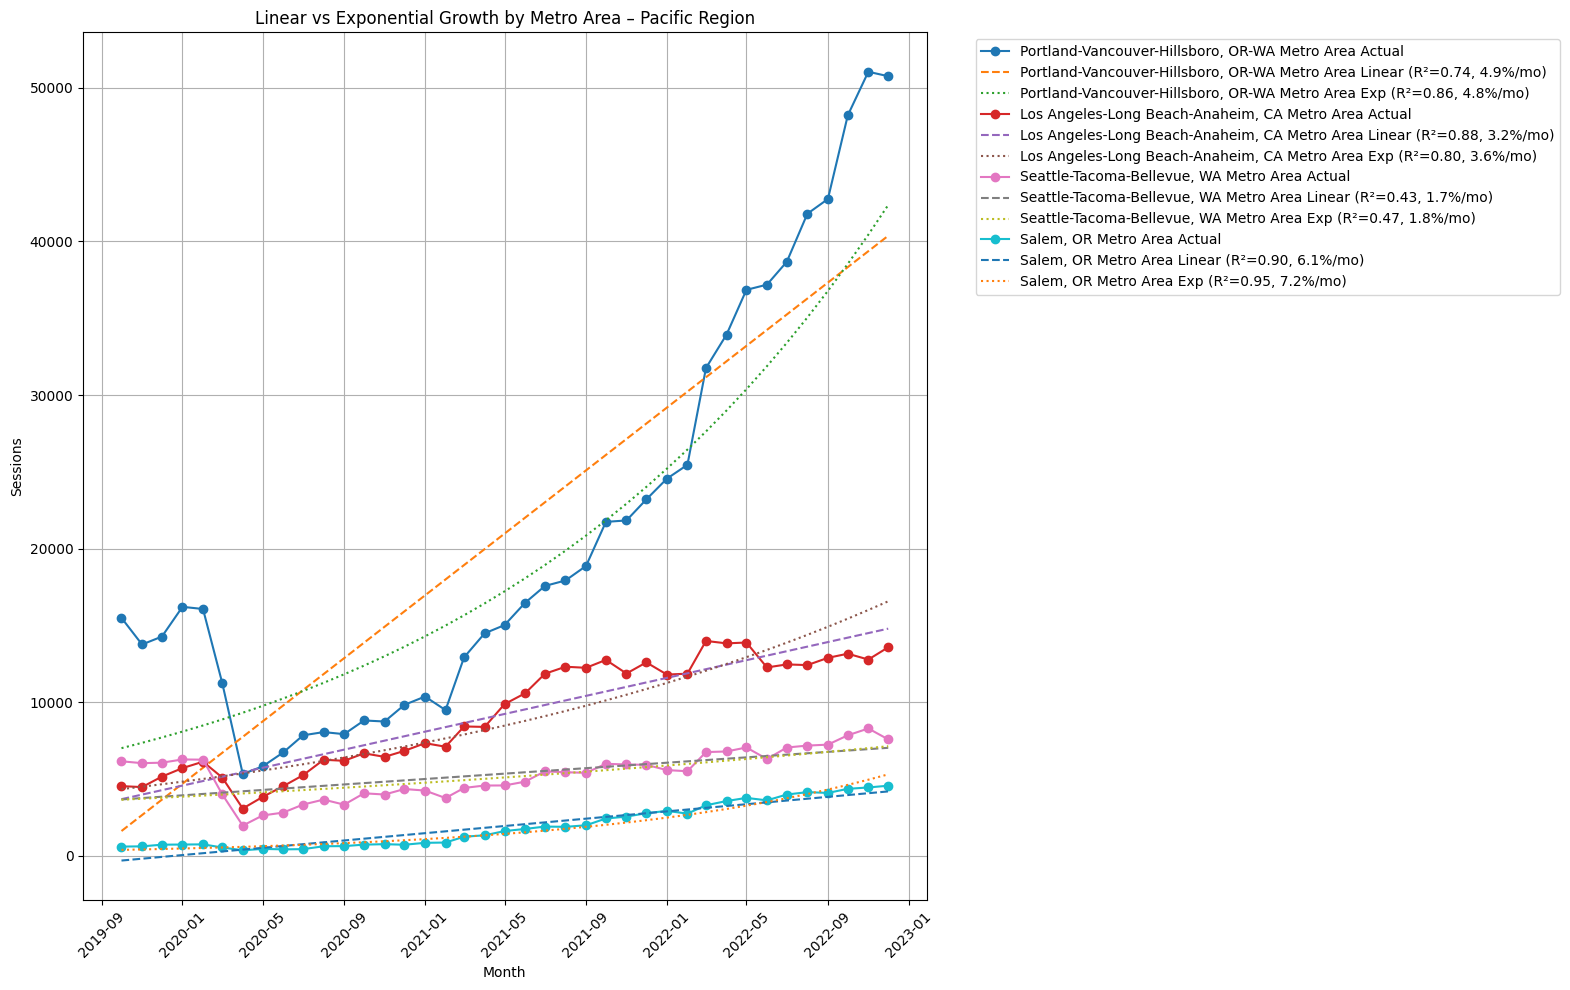

In [ ]:
non_undesignated_data = pacific_data[pacific_data['metro_area'] != 'Undesignated']
top_metros_pacific = non_undesignated_data['metro_area'].value_counts().head(5).index.tolist()

# Get monthly session counts by metro area
metro_monthly_pacific = pacific_data[pacific_data['metro_area'].isin(top_metros_pacific)] \
    .groupby(['year_month', 'metro_area'])['session_id'].count().reset_index()

# Ensure datetime format
metro_monthly_pacific['year_month'] = pd.to_datetime(metro_monthly_pacific['year_month'])

# Plotting and regression analysis per metro area
plt.figure(figsize=(16, 10))

for metro in top_metros_pacific:
    metro_data = metro_monthly_pacific[metro_monthly_pacific['metro_area'] == metro]
    x_numeric = metro_data['year_month'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = metro_data['session_id'].values

    # Linear regression
    lin_model = LinearRegression().fit(x_numeric, y)
    y_lin_pred = lin_model.predict(x_numeric)
    lin_r2 = lin_model.score(x_numeric, y)

    daily_growth = lin_model.coef_[0]
    monthly_growth_lin = daily_growth * 30.44
    monthly_percentage_lin = (monthly_growth_lin / y.mean()) * 100

    # Exponential regression
    log_y = np.log(y + 1e-6)  # small offset to avoid log(0)
    exp_model = LinearRegression().fit(x_numeric, log_y)
    y_exp_pred = np.exp(exp_model.predict(x_numeric))
    exp_r2 = r2_score(y, y_exp_pred)

    daily_exp_growth = exp_model.coef_[0]
    monthly_growth_exp = (np.exp(daily_exp_growth * 30.44) - 1) * 100

    # Plot actual data points
    plt.plot(metro_data['year_month'], y, 'o-', label=f'{metro} Actual')

    # Plot linear regression line
    plt.plot(metro_data['year_month'], y_lin_pred, '--',
             label=f'{metro} Linear (R²={lin_r2:.2f}, {monthly_percentage_lin:.1f}%/mo)')

    # Plot exponential regression line
    plt.plot(metro_data['year_month'], y_exp_pred, ':',
             label=f'{metro} Exp (R²={exp_r2:.2f}, {monthly_growth_exp:.1f}%/mo)')

plt.title('Linear vs Exponential Growth by Metro Area – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Sessions')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

#Analysis of top metro areas
Here we see that over time that the Metro area in Portland-Vancouver-Hillsboro, or Oregon and Washignton metro area, is the growing the fastest compared to others.

We also found that Portland-Vancouver_hillsboro had an exponential growth with avg of 4.8% increase per month in charging sessions.

LA, longbeach, anaheim in California has a linear trend, and is growing by 3.2% per month.

Seatle, tacoma, beelevue in WA, appears to be an exponential trend, r2 score of 0.47 > 0.43, and a 1.8% per month.

Salem in OR, is also a exponential with 0.95 > 0.90, and a growth of 7.2% per month.



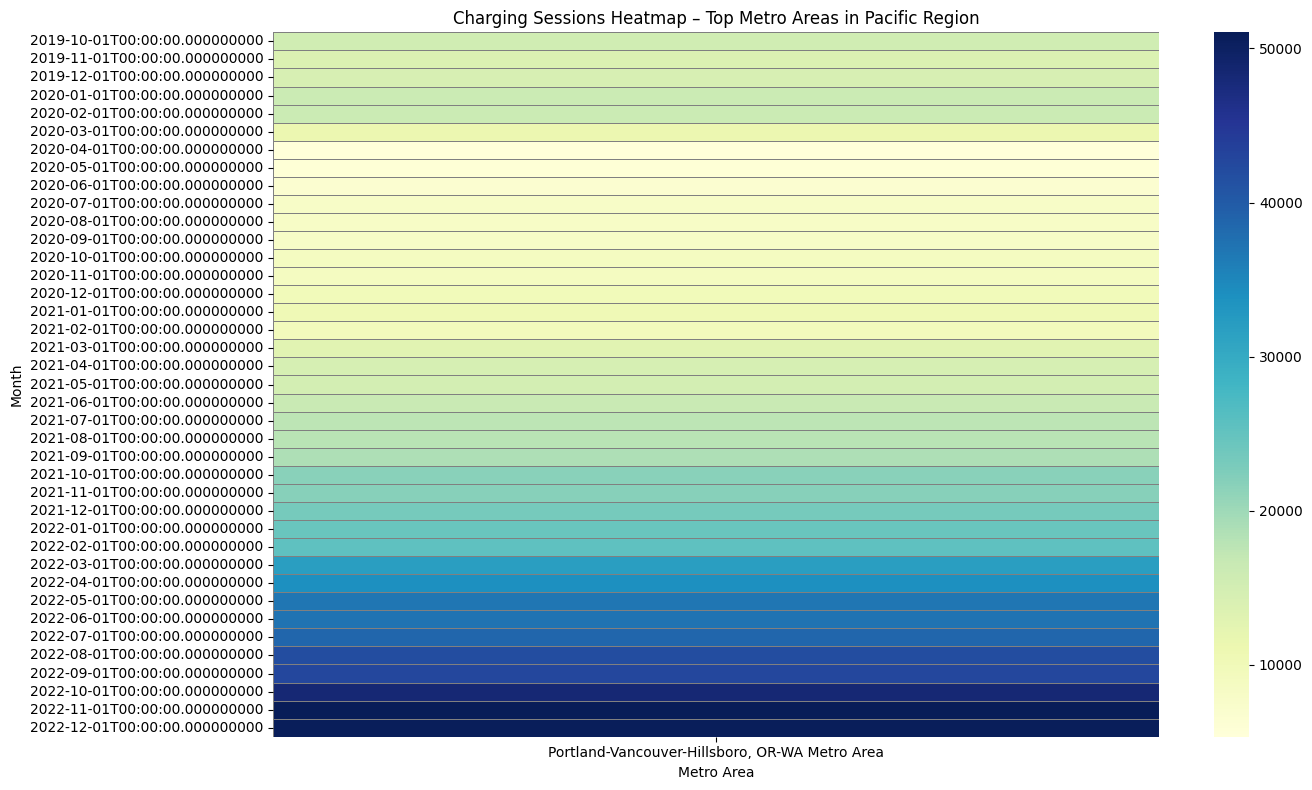

In [ ]:
top_metros = non_undesignated_data['metro_area'].value_counts().head(1).index.tolist()
heatmap_data = non_undesignated_data[non_undesignated_data['metro_area'].isin(top_metros)]

# Pivot table: rows = month, columns = metro area, values = session count
pivot = heatmap_data.groupby(['year_month', 'metro_area'])['session_id'].count().reset_index()
heatmap_table = pivot.pivot(index='year_month', columns='metro_area', values='session_id').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_table, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Charging Sessions Heatmap – Top Metro Areas in Pacific Region')
plt.xlabel('Metro Area')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

# Another Visualization for growth in the most popular area in the pacific region

It apears that this area experience huge growth around 2021.

Pre-Forecasting Diagnostic Checklist

24+ months = better for seasonality & forecasting

In [ ]:
pacific_monthly = session_data[session_data['region'] == 'Pacific'] \
    .groupby('year_month')['session_id'].count().reset_index()

num_months = pacific_monthly.shape[0]
print(f"Number of months: {num_months}")


Number of months: 39


Stationarity check

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(pacific_monthly['session_id'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: 0.9530370938534437
p-value: 0.9937448701435689


data is not stationary.

Prediction


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnp6vd2u_/nwtu55fm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnp6vd2u_/7ur7g4sc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14203', 'data', 'file=/tmp/tmpnp6vd2u_/nwtu55fm.json', 'init=/tmp/tmpnp6vd2u_/7ur7g4sc.json', 'output', 'file=/tmp/tmpnp6vd2u_/prophet_modelx11neajw/prophet_model-20250430033148.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:31:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:31:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


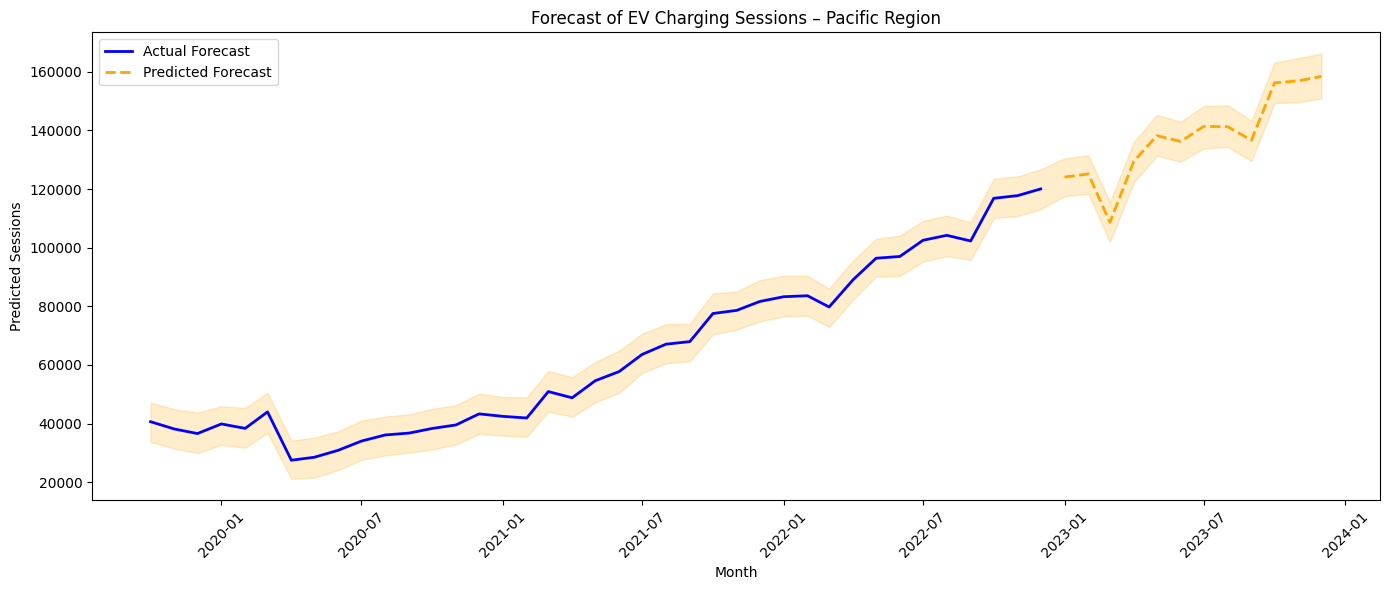

In [ ]:
from prophet import Prophet

# Step 1: Prepare data
pacific_data = session_data[session_data['region'] == 'Pacific'].copy()
pacific_data['start_datetime'] = pd.to_datetime(pacific_data['start_datetime'])
pacific_data['year_month'] = pacific_data['start_datetime'].dt.to_period('M').dt.to_timestamp()

# Step 2: Aggregate sessions per month
monthly_sessions = pacific_data.groupby('year_month')['session_id'].count().reset_index()
monthly_sessions.columns = ['ds', 'y']

# Step 3: Fit Prophet model
model = Prophet()
model.fit(monthly_sessions)

# Step 4: Make future dataframe and forecast
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Step 5: Merge forecast with historical data
forecast['is_forecast'] = forecast['ds'] > monthly_sessions['ds'].max()

# Step 6: Plot
plt.figure(figsize=(14, 6))

# Actual (historical)
sns.lineplot(data=forecast[~forecast['is_forecast']], x='ds', y='yhat', label='Actual Forecast', color='blue', linewidth=2)

# Forecast (future)
sns.lineplot(data=forecast[forecast['is_forecast']], x='ds', y='yhat', label='Predicted Forecast', color='orange', linestyle='--', linewidth=2)

# Optional: Plot uncertainty interval (optional, can be removed for clarity)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2, color='orange')

# Plot settings
plt.title('Forecast of EV Charging Sessions – Pacific Region')
plt.xlabel('Month')
plt.ylabel('Predicted Sessions')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

The number of charging sessions has been steadily increasing since late 2019.

There's a clear upward trend, especially strong from 2021 onward.

A dip is visible around early 2020 (likely pandemic-related), then strong recovery.

Forecast (Blue Line & Shaded Area):
The blue line shows the predicted number of sessions per month for ~12 months into the future.

The shaded region represents the uncertainty interval (95% CI), showing the model’s confidence.

Forecast predicts growth to continue, reaching over 160,000 sessions per month by end of 2023.

Model Behavior:
The model captured the trend very well.

It allows for flexible seasonality and adjusts to changes in momentum.

Confidence bands are reasonably tight, indicating a stable forecast.

Using Facebook Prophet, we forecast EV charging sessions in the Pacific region to continue increasing through 2023.